<a href="https://colab.research.google.com/github/segravjf/nba_player_similarity/blob/main/nba_player_cosine_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Player Similarity!

This notebook intends to create a similarity score for NBA players based on a combination of advanced stats, per possession stats, and some basic shooting stats. In doing so, we can then run this function to find "similar players" under these definitions to Bruce Brown.

In another notebook, we'll actually do some filtering to similar free agents to aid the Nuggets in finding good substitutes.

## What kind of variables should we use for the similarity score?

While there are a lot of good metrics out there, the intent of the similarity score is not to find players with similar *output*, but to find players with similar *styles*.

This doesn't preclude us from using simple counting and outcome stats where it makes sense (for example, things like efficiency may speak to both outcomes and playing style), but overall, we want to err on the side of finding players who make similar choices and have roughly similar skillsets over similar output.

Now, to the data itself. Sites like Basketball Reference keep a variety of advanced and possession-adjusted stats at our fingertips which do a pretty decent job of capturing most of the variables we want.

They're also pretty widely used in other research.

For example, a [segmentation analysis](https://global-uploads.webflow.com/5f1af76ed86d6771ad48324b/5f6a65517f9440891b8e35d0_Kalman_NBA_Line_up_Analysis.pdf) from Sloan Sports conference (Kalman & Bosch 2019) leveraged a good deal of the stats to create a clustering segmentation of different player positions, which shares a spirit with what we want to do here:

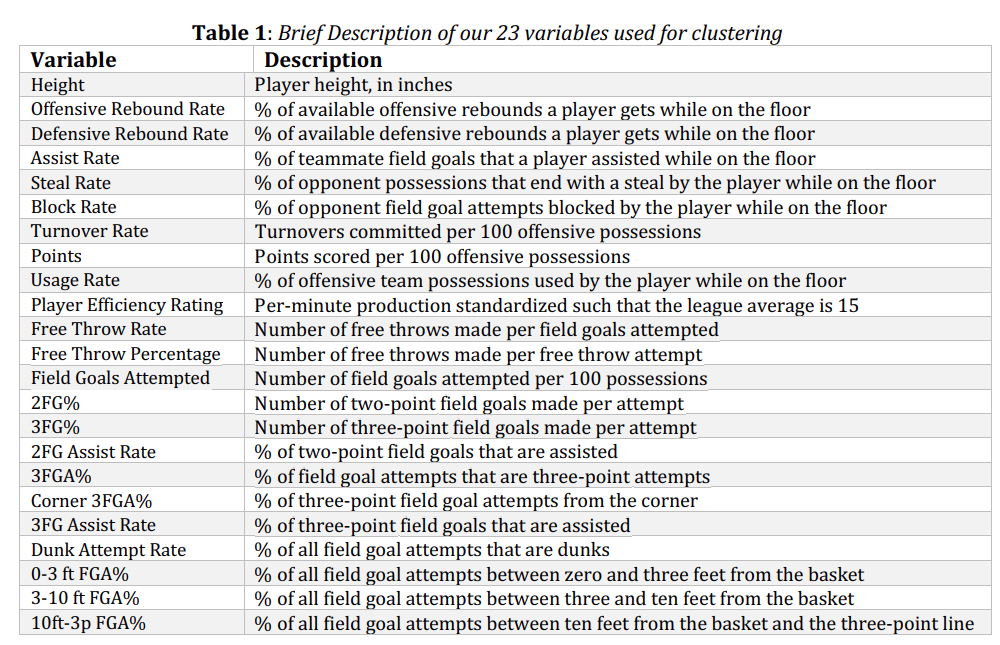

These stats are easily acquired from BR ([advanced](https://www.basketball-reference.com/leagues/NBA_2023_advanced.html), [shooting](https://www.basketball-reference.com/leagues/NBA_2023_shooting.html), [per-possession](https://www.basketball-reference.com/leagues/NBA_2023_per_poss.html)). Let's start with this set, with some slight modifications, and go from there.

In [ ]:
## Import modules
!pip install nba_api

import pandas as pd
import numpy as np
from scipy.stats import zscore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
## Pull player height
from nba_api.stats.static import players
from nba_api.stats.endpoints import commonplayerinfo

playerList = players.get_active_players()

for player in playerList[0:5]:
  print(player['id'])

1630173
203500
1628389
1630534
1630583


In [ ]:
## Get player height and age from NBA API
from nba_api.stats.endpoints import playerindex

playerindex = playerindex.PlayerIndex(
    season='2022-23'
).get_data_frames()[0]

## Start by looking at basic counting stats
playerindex.columns

Index(['PERSON_ID', 'PLAYER_LAST_NAME', 'PLAYER_FIRST_NAME', 'PLAYER_SLUG',
       'TEAM_ID', 'TEAM_SLUG', 'IS_DEFUNCT', 'TEAM_CITY', 'TEAM_NAME',
       'TEAM_ABBREVIATION', 'JERSEY_NUMBER', 'POSITION', 'HEIGHT', 'WEIGHT',
       'COLLEGE', 'COUNTRY', 'DRAFT_YEAR', 'DRAFT_ROUND', 'DRAFT_NUMBER',
       'ROSTER_STATUS', 'FROM_YEAR', 'TO_YEAR', 'PTS', 'REB', 'AST',
       'STATS_TIMEFRAME'],
      dtype='object')

In [ ]:
playerindex.head()

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,...,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,FROM_YEAR,TO_YEAR,PTS,REB,AST,STATS_TIMEFRAME
0,1630173,Achiuwa,Precious,precious-achiuwa,1610612761,raptors,0,Toronto,Raptors,TOR,...,2020.0,1.0,20.0,1.0,2020,2023,9.2,6.0,0.9,Season
1,203500,Adams,Steven,steven-adams,1610612763,grizzlies,0,Memphis,Grizzlies,MEM,...,2013.0,1.0,12.0,1.0,2013,2023,8.6,11.5,2.3,Season
2,1628389,Adebayo,Bam,bam-adebayo,1610612748,heat,0,Miami,Heat,MIA,...,2017.0,1.0,14.0,1.0,2017,2023,20.4,9.2,3.2,Season
3,1630534,Agbaji,Ochai,ochai-agbaji,1610612762,jazz,0,Utah,Jazz,UTA,...,2022.0,1.0,14.0,1.0,2022,2023,7.9,2.1,1.1,Season
4,1630583,Aldama,Santi,santi-aldama,1610612763,grizzlies,0,Memphis,Grizzlies,MEM,...,2021.0,1.0,30.0,1.0,2021,2023,9.0,4.8,1.3,Season


In [ ]:
## How many rows? For matching later
len(playerindex)

539

In [ ]:
## Adjust the height to inches, build a player name
playerindex[['HEIGHT_FT','HEIGHT_IN']] = playerindex['HEIGHT'].str.split('-',expand = True)
playerindex.head()

playerindex['HEIGHT_INCHES'] = playerindex['HEIGHT_FT'].astype(float) * 12.0 + playerindex['HEIGHT_IN'].astype(float)
playerindex['PLAYER_NAME'] = playerindex['PLAYER_FIRST_NAME'] + " " + playerindex['PLAYER_LAST_NAME']

playerindex[['PERSON_ID','PLAYER_NAME','HEIGHT','HEIGHT_FT','HEIGHT_IN','HEIGHT_INCHES']].head()

,PERSON_ID,PLAYER_NAME,HEIGHT,HEIGHT_FT,HEIGHT_IN,HEIGHT_INCHES
0,1630173,Precious Achiuwa,6-8,6,8,80.0
1,203500,Steven Adams,6-11,6,11,83.0
2,1628389,Bam Adebayo,6-9,6,9,81.0
3,1630534,Ochai Agbaji,6-5,6,5,77.0
4,1630583,Santi Aldama,7-0,7,0,84.0


In [ ]:
## Import some CSVs pulled from Basketball Reference from the 2022-2023 NBA season -- requires some manual intervention to select it due to Colab
from google.colab import files
uploaded = files.upload()

import io
adv = pd.read_csv(io.BytesIO(uploaded['NBA_2023_advanced.csv']))
pos = pd.read_csv(io.BytesIO(uploaded['NBA_2023_per_poss.csv']))
sht = pd.read_csv(io.BytesIO(uploaded['NBA_2023_shooting.csv']))

Saving NBA_2023_advanced.csv to NBA_2023_advanced.csv
Saving NBA_2023_per_poss.csv to NBA_2023_per_poss.csv
Saving NBA_2023_shooting.csv to NBA_2023_shooting.csv


In [ ]:
## Look at column names for these CSVs
print(adv.columns)
print(pos.columns)
print(sht.columns)

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'Unnamed: 23', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Player-additional'],
      dtype='object')
Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Unnamed: 29',
       'ORtg', 'DRtg', 'Player-additional'],
      dtype='object')
Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'FG%', 'Dist.',
       'Unnamed: 9', 'PCT_FG_2P', 'PCT_FG_0-3', 'PCT_FG_3-10', 'PCT_FG_10-16',
       'PCT_FG_16-3P', 'PCT_FG_3P', 'Unnamed: 16', 'FG%_2P', 'FG%_0-3',
       'FG%_3-10', 'FG%_10-16', 'FG%_16-3P', 'FG%_3P', 'Unnamed: 23',
       'PCT_AST_2P', 'PCT_AST_3P', 'Unnamed: 26', 'DUNK_%FGA', 'DUNK_NUM',
       'Unnamed: 29', 'CORNER_PCT_3PA', 'CORNER_3

In [ ]:
## Drop unnecessary columns
adv = adv.drop(columns=['Unnamed: 23','Player-additional'])
pos = pos.drop(columns=['Unnamed: 29','Player-additional'])
sht = sht.drop(columns=['Unnamed: 9','Unnamed: 16','Unnamed: 23','Unnamed: 26','Unnamed: 29','Unnamed: 32','ADDITIONAL'])

In [ ]:
## Quick glance at the data
adv.head()

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Precious Achiuwa,C,23,TOR,55,1140,15.2,0.554,0.267,...,11.4,19.4,0.8,1.4,2.2,0.093,-1.4,-0.8,-2.3,-0.1
1,2,Steven Adams,C,29,MEM,42,1133,17.5,0.564,0.004,...,19.8,14.6,1.3,2.1,3.4,0.144,-0.3,0.9,0.6,0.7
2,3,Bam Adebayo,C,25,MIA,75,2598,20.1,0.592,0.011,...,12.7,25.2,3.6,3.8,7.4,0.137,0.8,0.8,1.5,2.3
3,4,Ochai Agbaji,SG,22,UTA,59,1209,9.5,0.561,0.591,...,9.0,15.8,0.9,0.4,1.3,0.053,-1.7,-1.4,-3.0,-0.3
4,5,Santi Aldama,PF,22,MEM,77,1682,13.9,0.591,0.507,...,9.3,16.0,2.1,2.4,4.6,0.130,-0.3,0.8,0.5,1.1


In [ ]:
## Look at per poss data
pos.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
0,1,Precious Achiuwa,C,23,TOR,55,12,1140,8.5,17.5,...,9.9,14.2,2.2,1.3,1.3,2.6,4.4,22.0,112.0,113
1,2,Steven Adams,C,29,MEM,42,42,1133,6.6,11.0,...,11.4,20.3,4.1,1.5,1.9,3.3,4.1,15.1,118.0,108
2,3,Bam Adebayo,C,25,MIA,75,75,2598,11.6,21.4,...,9.7,13.2,4.6,1.7,1.2,3.6,4.0,29.3,115.0,111
3,4,Ochai Agbaji,SG,22,UTA,59,22,1209,6.5,15.3,...,3.1,4.8,2.6,0.6,0.6,1.6,3.9,18.5,115.0,121
4,5,Santi Aldama,PF,22,MEM,77,20,1682,7.0,14.8,...,8.1,10.5,2.7,1.3,1.4,1.7,4.0,19.7,120.0,111


In [ ]:
## Look at shooting data
sht.head()

,Rk,Player,Pos,Age,Tm,G,MP,FG%,Dist.,PCT_FG_2P,...,FG%_16-3P,FG%_3P,PCT_AST_2P,PCT_AST_3P,DUNK_%FGA,DUNK_NUM,CORNER_PCT_3PA,CORNER_3P%,HEAVE_ATT,HEAVE_MAKE
0,1,Precious Achiuwa,C,23,TOR,55,1140,0.485,9.8,0.733,...,0.200,0.269,0.629,1.000,0.141,49,0.444,0.250,1,0
1,2,Steven Adams,C,29,MEM,42,1133,0.597,2.6,0.996,...,NaN,0.000,0.503,NaN,0.163,41,1.000,0.000,0,0
2,3,Bam Adebayo,C,25,MIA,75,2598,0.540,7.4,0.989,...,0.288,0.083,0.601,1.000,0.136,140,0.000,NaN,1,0
3,4,Ochai Agbaji,SG,22,UTA,59,1209,0.427,16.9,0.409,...,0.444,0.355,0.762,0.988,0.054,17,0.412,0.457,0,0
4,5,Santi Aldama,PF,22,MEM,77,1682,0.470,14.6,0.493,...,0.444,0.353,0.680,0.968,0.118,54,0.391,0.365,1,0


In [ ]:
## Install a module to decode some of the specific Balkan state letters when we match Basketball Ref Data with NBA API data
!pip install unidecode
from unidecode import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.2 MB/s eta 0:00:00


In [ ]:
## BR will give players who played on multiple teams multiple rows, as well as the totals
## This is weird because we want their season totals and not their per-team totals
## We want to do something different
## Let's some munging to get rid of the TOT team and make it the most recent team from NBA.com

## Find these players
multi_team_players = adv[adv['Tm'] == 'TOT'][['Player','Tm']]
## Remove some Balkan characters for the merge
multi_team_players['player_decoded'] = multi_team_players['Player'].apply(unidecode)
## Give Kevin Knox II his II
multi_team_players.player_decoded[multi_team_players.player_decoded=='Kevin Knox'] = 'Kevin Knox II'

multi_team_players.head()


,Player,Tm,player_decoded
5,Nickeil Alexander-Walker,TOT,Nickeil Alexander-Walker
14,Ryan Arcidiacono,TOT,Ryan Arcidiacono
21,Mo Bamba,TOT,Mo Bamba
29,Will Barton,TOT,Will Barton
33,Darius Bazley,TOT,Darius Bazley


In [ ]:
## Pull in latest team from playerindex
right = playerindex[['PLAYER_NAME','HEIGHT_INCHES','TEAM_ABBREVIATION']]
matched = pd.merge(left=multi_team_players, right=right, how='left', left_on=['player_decoded'], right_on=['PLAYER_NAME'],indicator = True)

matched

,Player,Tm,player_decoded,PLAYER_NAME,HEIGHT_INCHES,TEAM_ABBREVIATION,_merge
0,Nickeil Alexander-Walker,TOT,Nickeil Alexander-Walker,Nickeil Alexander-Walker,77.0,MIN,both
1,Ryan Arcidiacono,TOT,Ryan Arcidiacono,Ryan Arcidiacono,75.0,None,both
2,Mo Bamba,TOT,Mo Bamba,Mo Bamba,84.0,LAL,both
3,Will Barton,TOT,Will Barton,Will Barton,77.0,TOR,both
4,Darius Bazley,TOT,Darius Bazley,Darius Bazley,81.0,PHX,both
...,...,...,...,...,...,...,...
65,Juan Toscano-Anderson,TOT,Juan Toscano-Anderson,Juan Toscano-Anderson,78.0,UTA,both
66,Jarred Vanderbilt,TOT,Jarred Vanderbilt,Jarred Vanderbilt,80.0,LAL,both
67,T.J. Warren,TOT,T.J. Warren,T.J. Warren,80.0,PHX,both
68,Russell Westbrook,TOT,Russell Westbrook,Russell Westbrook,75.0,LAC,both


In [ ]:
## Quick data check for a clean merge
matched.groupby(['_merge']).Tm.count()

_merge
left_only      0
right_only     0
both          70
Name: Tm, dtype: int64

In [ ]:
## Which teams are we switching to?
matched.groupby(['TEAM_ABBREVIATION'], dropna = False).Player.count()

TEAM_ABBREVIATION
ATL    3
BKN    5
BOS    2
CHA    1
CHI    2
CLE    1
DAL    4
DEN    2
DET    3
GSW    1
HOU    1
IND    2
LAC    4
LAL    5
MEM    1
MIA    1
MIL    1
MIN    3
NOP    1
NYK    1
OKC    1
ORL    1
PHI    2
PHX    5
POR    3
SAC    1
SAS    3
TOR    2
UTA    2
WAS    1
NaN    5
Name: Player, dtype: int64

In [ ]:
## Build a function to clean up the first dataset
def clean_up_munge(df, merged_df):
  ## Create a subset of the original dataset just for the matched dataset
  tots = df[df['Tm'] == 'TOT']
  tots = tots.drop(columns='Tm')
  tots_match = pd.merge(left = merged_df, right = tots, on = 'Player', how = 'left')
  ## In the new dataset, remove the non-TOT values
  tots_match = tots_match[tots_match['Tm'] == 'TOT']
  ## Update the team column to the correct team and drop all columns not in original df
  tots_match = tots_match.drop(columns=['Tm','PLAYER_NAME','HEIGHT_INCHES','_merge','player_decoded'])
  tots_match = tots_match.rename(columns={'TEAM_ABBREVIATION':'Tm'})
  ## Drop these players from the original
  remove_tots = pd.merge(df, tots_match['Player'], on = 'Player', how='outer', indicator = True)
  remove_tots = remove_tots.loc[remove_tots._merge == 'left_only']
  remove_tots = remove_tots.drop(columns=['_merge'])
  ## Concatenate the new values on the bottom of the original
  clean_df = pd.concat([tots_match, remove_tots], ignore_index=True)
  return clean_df

In [ ]:
## Clean up the advanced dataset
adv2 = clean_up_munge(adv, matched)
adv2[adv2.Player == 'Mo Bamba']

,Player,Tm,Rk,Pos,Age,G,MP,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
2,Mo Bamba,LAL,22,C,24,49,769,15.7,0.602,0.515,...,10.1,16.6,1.1,1.1,2.2,0.139,-0.2,0.7,0.5,0.5


In [ ]:
## Clean up possession dataset
pos2 = clean_up_munge(pos, matched)
pos2[pos2.Player == 'Mo Bamba']

,Player,Tm,Rk,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
2,Mo Bamba,LAL,26,C,24,49,7,769,7.3,15.1,...,10.5,14.1,2.9,0.8,2.7,1.9,6.6,20.3,121.0,111


In [ ]:
## Clean up shooting dataset
sht2 = clean_up_munge(sht, matched)
sht2[sht2.Player == 'Mo Bamba']

,Player,Tm,Rk,Pos,Age,G,MP,FG%,Dist.,PCT_FG_2P,...,FG%_16-3P,FG%_3P,PCT_AST_2P,PCT_AST_3P,DUNK_%FGA,DUNK_NUM,CORNER_PCT_3PA,CORNER_3P%,HEAVE_ATT,HEAVE_MAKE
2,Mo Bamba,LAL,22,C,24,49,769,0.485,15.1,0.485,...,0.286,0.387,0.754,1.0,0.178,36,0.113,0.357,0,0


Ok, now we look to pick metrics to consider for the similarity score. This is a subjective exercise. We want to cover a few different dimensions to think about what Bruce Brown brings to the Nuggets off the bench.
* Physical presence: the Nuggets are a tall team. Brown is a 6'4" guard/forward. *Measures*: height, dunk attempt rate (per possession?)
* Ballhandling and driving: needs to lead the second unit when Jamal Murray sits. *Measures*: usage rate, % of FG attempts within 3 ft, Turnover-to-assist ratio, % of FGs assisted., field goals attempted per possession, free throw rate.
* Defense: the core of the bench unit is to up the defensive presence of the team to account for an offensive playmaker (usually Jokic or Murray) sitting on the bench. *Measures*: block %, rebound %, steal %
* 3 Point Shooting: able to stretch the floor and catch/shoot. *Measures*: % of FG attempts that are 3P, % of 3PA that are corner 3s, % of 3Ps that are assisted.


Player index
- Height

Advanced stats
- USG%: Usage rate
- 3PAr: 3P Attempt Rate
- TOV%: Turnovers per possession
- BLK%: Block %
- TRB%: Rebound %
- STL%: Steal %

Possession stats
- FGA: FGA per 100 possessions
- FTA: Free throw attempts per 100 poss


Shooting stats
- PCT_FG_3P: 3P Shot Share
- CORNER_PCT_3PA: % of 3PA from corner
- PCT_AST_3P: % of 3P shots assisted
- PCT_PG_0-3: % of FG attempts within 3 ft
- DUNK_%FGA: % of FG attempts that are dunks
- PCT_AST_2P: % of 2 pt FGs assisted




In [ ]:
# Let's assemble a dataset of these key stats

## Subset the advanced stats to the key metrics we care about for all players
adv_raw = adv2[['Player','Tm','Pos','USG%','3PAr','TOV%','BLK%','TRB%','STL%']]
pos_raw = pos2[['Player','Tm','FGA','FTA','PTS']]
sht_raw = sht2[['Player','Tm','PCT_FG_3P','CORNER_PCT_3PA','PCT_AST_2P','PCT_AST_3P','PCT_FG_0-3','DUNK_%FGA']]

## Merge together the three datasets in two steps
stg1_merge = pd.merge(left=adv_raw, right=pos_raw, how='inner', on=['Player','Tm'])
stats_raw = pd.merge(left=stg1_merge, right=sht_raw, how='inner', on=['Player','Tm'])

print(stats_raw.columns)
print(len(stats_raw))

Index(['Player', 'Tm', 'Pos', 'USG%', '3PAr', 'TOV%', 'BLK%', 'TRB%', 'STL%',
       'FGA', 'FTA', 'PTS', 'PCT_FG_3P', 'CORNER_PCT_3PA', 'PCT_AST_2P',
       'PCT_AST_3P', 'PCT_FG_0-3', 'DUNK_%FGA'],
      dtype='object')
539


In [ ]:
## Write a cosine similarity score
def cosine_similarity(vector1, vector2):
  dot_product = np.dot(vector1, vector2)
  norm1 = np.linalg.norm(vector1)
  norm2 = np.linalg.norm(vector2)
  similarity = dot_product / (norm1 * norm2)
  return similarity

In [ ]:
## Prep some functions for a similarity score!

def find_similar_players(df, player, positions):

  ## Filter to only the positions of interest
  pos_match = df[df['Pos'].isin(positions)]

  ## Within the subgroup, convert all numerical columns into z-scores
  numeric_cols = df.select_dtypes(include=[np.number]).columns
  df_z = pos_match[numeric_cols].apply(lambda x: zscore(x, nan_policy='omit'))

  ## Add the names and teams back
  names_and_teams = pos_match[['Player','Tm','Pos']]
  df_z_named = pd.merge(left=df_z, right=names_and_teams, left_index = True, right_index = True)

  ## Pull out the player's stats being named
  selected_stats = df_z_named[df_z_named['Player'] == player].iloc[:,:-3].values.flatten()
  similarity_scores = []

  for _, row in df_z_named.iterrows():
    player_stats = row.iloc[:-3].values.flatten()
    similarity = cosine_similarity(selected_stats, player_stats)
    similarity_scores.append(similarity)

  pos_match['Similarity'] = similarity_scores
  df_sorted = pos_match.sort_values(by='Similarity', ascending=False)

  return df_sorted

In [ ]:
bruce_sims = find_similar_players(stats_raw, 'Bruce Brown', ['PG','SG','SF'])

<ipython-input-24-bdcf4cc41ec9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_match['Similarity'] = similarity_scores


In [ ]:
bruce_sims.head(20)

,Player,Tm,Pos,USG%,3PAr,TOV%,BLK%,TRB%,STL%,FGA,FTA,PTS,PCT_FG_3P,CORNER_PCT_3PA,PCT_AST_2P,PCT_AST_3P,PCT_FG_0-3,DUNK_%FGA,Similarity
120,Bruce Brown,DEN,SF,17.8,0.343,13.2,2.0,8.3,1.9,15.9,3.3,19.8,0.343,0.398,0.551,0.923,0.266,0.076,1.000000
347,Jaden McDaniels,MIN,SF,15.8,0.376,12.6,2.7,7.1,1.5,14.1,2.8,18.7,0.376,0.506,0.658,0.991,0.288,0.115,0.921820
44,Jalen McDaniels,PHI,SF,17.2,0.376,12.1,1.6,9.9,2.1,15.5,3.5,18.9,0.376,0.392,0.578,0.974,0.316,0.076,0.921409
116,Christian Braun,DEN,SG,13.0,0.332,9.9,1.3,8.8,1.7,12.0,2.7,14.9,0.332,0.417,0.670,0.941,0.360,0.114,0.886224
330,Terance Mann,LAC,SG,15.3,0.378,12.2,1.0,8.3,1.1,13.7,3.1,18.7,0.378,0.495,0.554,0.883,0.330,0.107,0.884022
172,Hamidou Diallo,DET,SF,21.8,0.056,13.9,1.4,10.8,2.6,18.2,7.2,25.4,0.056,0.524,0.643,1.000,0.443,0.139,0.876340
222,Javonte Green,CHI,SF,13.6,0.324,13.5,4.2,10.4,2.4,11.0,4.6,16.7,0.324,0.457,0.667,1.000,0.481,0.222,0.873065
464,Lamar Stevens,CLE,SF,13.6,0.330,7.9,1.6,10.9,1.2,12.9,2.6,14.7,0.330,0.642,0.788,1.000,0.340,0.108,0.870256
506,Peyton Watson,DEN,SG,17.7,0.237,10.6,5.2,11.4,0.5,15.5,5.3,19.7,0.237,0.429,0.652,1.000,0.305,0.119,0.863600
520,Jeenathan Williams,POR,SG,15.2,0.205,9.0,1.4,6.8,1.2,15.0,1.2,20.3,0.205,0.500,0.667,1.000,0.615,0.154,0.862895


In [ ]:
## Download as a CSV
from google.colab import drive
drive.mount('/content/drive')

bruce_sims.to_csv('/content/drive/My Drive/Colab Notebooks/nba_player_similarity/bruce_brown_similar_players.csv', index=False)

Mounted at /content/drive
